In [1]:
from __future__ import annotations

import pandas as pd
import numpy as np
from IPython.display import display
from scipy.interpolate import splrep, BSpline

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 9
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['path.simplify'] = True
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['svg.hashsalt'] = '42'
%matplotlib inline

import plot
from plot import Workload

In [2]:
# The name of the system.
# Kronos was an anonymized submission name. Perseus is the real name.
# system_name = "Kronos"
system_name = "Perseus"

In [3]:
# The data root directory.
# When new data is collected, you can create a separate data root directory while replicating the
# structure of `sosp24_data` and point the rest of the notebook to look into that directory.
plot.DATA = "sosp24_data"

## Iteration time-energy frontier

*Reproduces Figure 9*

This section visualizes all of the experimentally measured iteration time-energy frontiers of Perseus and the two Zeus baselines. These frontiers form the basis of deriving numbers in other experimental sections, so we're showing this first in the notebook. There are three subsections:
- `A100 PP4`: 4-stage pipeline parallel results on A100 GPUs for the five workloads.
- `A40 PP8`: 8-stage pipeline parallel results on A40 GPUs for the five workloads.
- `A40 DP2 TP2 PP4`: 3D parallelism (data parallel degree 2, tensor parallel degree 2, and 4-stage pipeline parallel) results on A40 GPUs for GPT-3 6.7B.

The first figure from each cell constitute *Figure 9*, in order.

In [4]:
def plot_comparison_pareto(
    w: Workload,
    fig, ax,
    xlim=(None, None),
    ylim=(None, None),
    warmup_steps: int = 2,
    warmup_iters: int = 2,
    draw_legend: bool = False,
) -> None:
    print(w)
    
    font_size = 10
    markersize = 5
    ax.set_xlabel("Iteration Time (seconds)", fontsize=font_size)
    ax.set_ylabel("Iteration Energy (Joules)", fontsize=font_size)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    
    # ZeusGlobal
    zg_df = w.get_zeus_df('global').sort_index(ascending=False)
    ax.plot(zg_df["time"], zg_df["energy"], label="ZeusGlobal", marker=".", markersize=markersize, color="black")
    
    # ZeusPerStage
    if w.pp > 1:  # ZeusPerStage and ZeusGlobal coincides when there is no pipeline parallelism.
        zl_df = w.get_zeus_df('local').sort_index(ascending=False)
        ax.plot(zl_df["time"], zl_df["energy"], label="ZeusPerStage", marker=".", markersize=markersize, color="darkgoldenrod")

    # Perseus
    perseus_df = w.get_perseus_df(warmup_steps=warmup_steps, warmup_iters=warmup_iters).sort_index()
    ax.plot(perseus_df["time"], perseus_df["energy"], label=system_name, marker=".", markersize=markersize, color="#FF914D")

    # Vertical dotted line at shortest iteration time
    ax.axvline(zg_df.time.iloc[-1], color="black", linestyle="dotted")
    
    if draw_legend:
        fig.legend(loc="upper right", bbox_to_anchor=legend_anchor, fontsize=font_size)

    plt.tight_layout(pad=0.1, h_pad=0.0, w_pad=0.0)

### A100 PP4

framework='merak' model_name='gpt3-xl' partition_method='custom:0,8,14,21,27' dp=1 tp=1 pp=4 gpu_type='A100' microbatch_size=8 num_microbatches=128 point_solution_path=None
Reading Perseus results from sosp24_data/perseus/A100/dp1+pp4+tp1/merak+gpt3-xl+custom:0,8,14,21,27+dp1+pp4+tp1+mbs8+nmb128+PointSolution
framework='merak' model_name='bert-huge-uncased' partition_method='custom:0,8,14,20,26' dp=1 tp=1 pp=4 gpu_type='A100' microbatch_size=8 num_microbatches=32 point_solution_path=None
Reading Perseus results from sosp24_data/perseus/A100/dp1+pp4+tp1/merak+bert-huge-uncased+custom:0,8,14,20,26+dp1+pp4+tp1+mbs8+nmb32+PointSolution
framework='merak' model_name='t5-3b' partition_method='custom:0,16,33,53,74' dp=1 tp=1 pp=4 gpu_type='A100' microbatch_size=4 num_microbatches=32 point_solution_path=None
Reading Perseus results from sosp24_data/perseus/A100/dp1+pp4+tp1/merak+t5-3b+custom:0,16,33,53,74+dp1+pp4+tp1+mbs4+nmb32+PointSolution
framework='merak' model_name='bloom-3b' partition_met

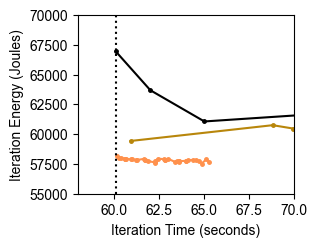

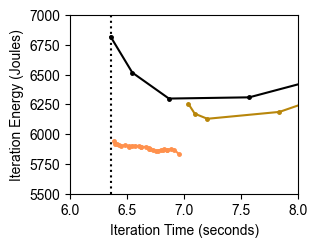

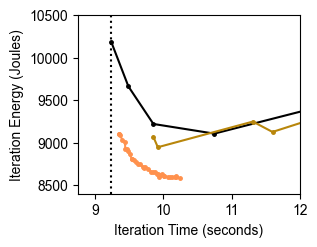

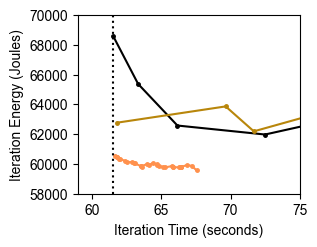

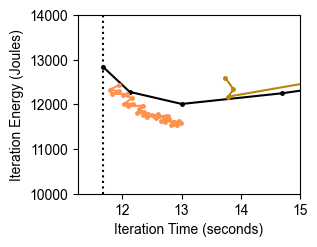

In [5]:
gpu_type = "A100"
dp, tp, pp = 1, 1, 4

w = Workload(
    framework="merak",
    model_name="gpt3-xl", partition_method="custom:0,8,14,21,27",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
fig, ax = plt.subplots(figsize=(3, 2.3), tight_layout=True)
plot_comparison_pareto(
    w=w, fig=fig, ax=ax,
    xlim=(58, 70), ylim=(55000, 70000),
)

w = Workload(
    framework="merak",
    model_name="bert-huge-uncased", partition_method="custom:0,8,14,20,26",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
fig, ax = plt.subplots(figsize=(3, 2.3), tight_layout=True)
plot_comparison_pareto(
    w=w, fig=fig, ax=ax,
    xlim=(6, 8), ylim=(5500, 7000),
)

w = Workload(
    framework="merak",
    model_name="t5-3b", partition_method="custom:0,16,33,53,74",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
fig, ax = plt.subplots(figsize=(3, 2.3), tight_layout=True)
plot_comparison_pareto(
    w=w, fig=fig, ax=ax,
    xlim=(8.75, 12), ylim=(8400, 10500),
)

w = Workload(
    framework="merak",
    model_name="bloom-3b", partition_method="custom:0,10,18,26,32",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
fig, ax = plt.subplots(figsize=(3, 2.3), tight_layout=True)
plot_comparison_pareto(
    w=w, fig=fig, ax=ax,
    xlim=(59, 75), ylim=(58000, 70000),
)

w = Workload(
    framework="merak",
    model_name="wide-resnet101_8", partition_method="custom:0,7,16,25,34",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
fig, ax = plt.subplots(figsize=(3, 2.3), tight_layout=True)
plot_comparison_pareto(
    w=w, fig=fig, ax=ax,
    xlim=(11.25, 15), ylim=(10000, 14000),
)

### A40 PP8

framework='merak' model_name='gpt3-2.7b' partition_method='uniform_transformer' dp=1 tp=1 pp=8 gpu_type='A40' microbatch_size=4 num_microbatches=256 point_solution_path=None
Reading Perseus results from sosp24_data/perseus/A40/dp1+pp8+tp1/merak+gpt3-2.7b+uniform_transformer+dp1+pp8+tp1+mbs4+nmb256+PointSolution
framework='merak' model_name='bert-huge-uncased' partition_method='uniform_transformer' dp=1 tp=1 pp=8 gpu_type='A40' microbatch_size=8 num_microbatches=32 point_solution_path=None
Reading Perseus results from sosp24_data/perseus/A40/dp1+pp8+tp1/merak+bert-huge-uncased+uniform_transformer+dp1+pp8+tp1+mbs8+nmb32+PointSolution
framework='merak' model_name='t5-3b' partition_method='custom:0,9,16,24,33,43,53,63,74' dp=1 tp=1 pp=8 gpu_type='A40' microbatch_size=4 num_microbatches=32 point_solution_path=None
Reading Perseus results from sosp24_data/perseus/A40/dp1+pp8+tp1/merak+t5-3b+custom:0,9,16,24,33,43,53,63,74+dp1+pp8+tp1+mbs4+nmb32+PointSolution
framework='merak' model_name='blo

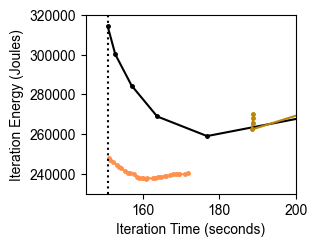

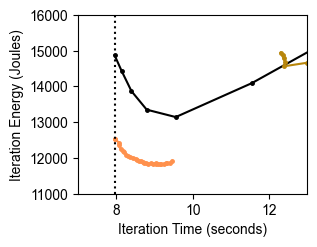

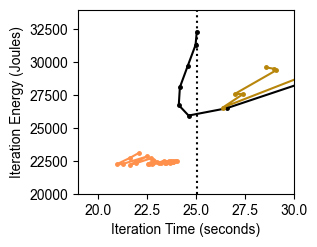

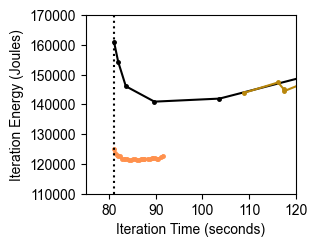

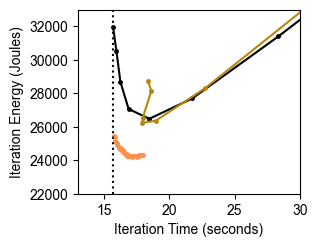

In [6]:
gpu_type = "A40"
dp, tp, pp = 1, 1, 8

w = Workload(
    framework="merak",
    model_name="gpt3-2.7b", partition_method="uniform_transformer",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
fig, ax = plt.subplots(figsize=(3, 2.3), tight_layout=True)
plot_comparison_pareto(
    w=w, fig=fig, ax=ax,
    xlim=(145, 200), ylim=(230000, 320000),
)

w = Workload(
    framework="merak",
    model_name="bert-huge-uncased", partition_method="uniform_transformer",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
fig, ax = plt.subplots(figsize=(3, 2.3), tight_layout=True)
plot_comparison_pareto(
    w=w, fig=fig, ax=ax,
    xlim=(7, 13), ylim=(11000, 16000),
)

w = Workload(
    framework="merak",
    model_name="t5-3b", partition_method="custom:0,9,16,24,33,43,53,63,74",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
fig, ax = plt.subplots(figsize=(3, 2.3), tight_layout=True)
plot_comparison_pareto(
    w=w, fig=fig, ax=ax,
    xlim=(19, 30), ylim=(20000, 34000),
)

w = Workload(
    framework="merak",
    model_name="bloom-3b", partition_method="custom:0,6,10,14,18,22,26,30,32",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
fig, ax = plt.subplots(figsize=(3, 2.3), tight_layout=True)
plot_comparison_pareto(
    w=w, fig=fig, ax=ax,
    xlim=(75, 120), ylim=(110000, 170000),
)

w = Workload(
    framework="merak",
    model_name="wide-resnet101_8", partition_method="custom:0,4,9,13,17,21,25,30,34",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
fig, ax = plt.subplots(figsize=(3, 2.3), tight_layout=True)
plot_comparison_pareto(
    w=w, fig=fig, ax=ax,
    xlim=(13, 30), ylim=(22000, 33000),
)

### A40 DP2 TP2 PP4

framework='merak' model_name='gpt3-6.7b' partition_method='uniform_transformer' dp=2 tp=2 pp=4 gpu_type='A40' microbatch_size=4 num_microbatches=64 point_solution_path=None
Reading Perseus results from sosp24_data/perseus/A40/dp2+pp4+tp2/merak+gpt3-6.7b+uniform_transformer+dp2+pp4+tp2+mbs4+nmb64+PointSolution3D


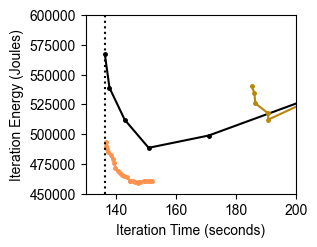

In [7]:
gpu_type = "A40"
dp, tp, pp = 2, 2, 4

w = Workload(
    framework="merak",
    model_name="gpt3-6.7b", partition_method="uniform_transformer",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
fig, ax = plt.subplots(figsize=(3, 2.3), tight_layout=True)
plot_comparison_pareto(
    w=w, fig=fig, ax=ax,
    xlim=(130, 200), ylim=(450000, 600000),
    warmup_iters=0,
)

## Energy savings with and without slowdown

*Reproduces Table 3 and Table 4*

In the previous section, we just visualized the experimentally measured raw iteration time-energy frontiers for all of our workloads. With these raw numbers, we generate energy savings numbers with and without stragglers.

In [8]:
def print_savings(w: Workload, slowdown_factors: list[float]) -> None:
    print(w)
    
    num_gpus = w.dp * w.tp * w.pp
    if w.gpu_type == "A40":
        p_blocking = 70.38
    elif w.gpu_type == "A100":
        p_blocking = 83.64
    else:
        raise ValueError(f"Unsupported GPU type: {w.gpu_type}")
    print(f"{num_gpus=}, {p_blocking=}")
    
    zg_df = w.get_zeus_df("global").sort_index(ascending=False)
    baseline_time, baseline_energy = zg_df.iloc[-1].time, zg_df.iloc[-1].energy
    
    envpipe_time, envpipe_energy = w.get_envpipe_time_energy(warmup_steps=2, warmup_iters=2)
    
    perseus_df = w.get_perseus_df(warmup_steps=2, warmup_iters=2)
    
    print()
    print("Table 3: Intrinsic energy bloat without stragglers")
    perseus_time, perseus_energy = perseus_df.iloc[-1].time, perseus_df.iloc[-1].energy
    print(
        f"  {system_name}: Energy reduction {reduction_percent(baseline_energy, perseus_energy):.1f}%, "
        f"slowdown {slowdown_percent(baseline_time, perseus_time):.1f}%"
    )
    print(
        f"  EnvPipe: Energy reduction {reduction_percent(baseline_energy, envpipe_energy):.1f}%, "
        f"slowdown {slowdown_percent(baseline_time, envpipe_time):.1f}%"
    )
    
    print()
    print("Table 4: Intrinsic + extrinsic energy bloat with varying stragglers")
    for slowdown_factor in slowdown_factors:
        print(f"Slowdown factor {slowdown_factor}:")
        straggler_time = baseline_time * slowdown_factor
        filtered_df = perseus_df.query(f"time <= {straggler_time}")
        if filtered_df.empty:
            print("  Impossible")
            continue
        # When we slow down the pipeline due to a straggler, we are also removing communication blocking energy.
        # When a straggler exists, without Perseus, the pipeline would have run for `baseline_time` and blocked for the remaining time.
        local_baseline_energy = baseline_energy + (straggler_time - baseline_time) * num_gpus * p_blocking
        # Perseus may not have been able to slow down to the end of `straggler_time`, so we need to add the blocking energy similarly.
        perseus_time, perseus_energy = filtered_df.iloc[0].time, filtered_df.iloc[0].energy
        perseus_energy += (straggler_time - perseus_time) * num_gpus * p_blocking
        # EnvPipe cannot slow down.
        local_envpipe_energy = envpipe_energy + (straggler_time - envpipe_time) * num_gpus * p_blocking
        print(f"  {system_name} energy reduction {reduction_percent(local_baseline_energy, perseus_energy):.1f}%")
        print(f"  EnvPipe energy reduction {reduction_percent(local_baseline_energy, local_envpipe_energy):.1f}%")
        
    print("=============================================================\n")
          
def slowdown_percent(base: float, target: float) -> float:
    return max((target / base - 1) * 100.0, 0.0)

def reduction_percent(base: float, target: float) -> float:
    return (1 - target / base) * 100.0

### A100 PP4

In [9]:
slowdown_factors = [1.05, 1.10, 1.20, 1.30, 1.40, 1.50]

gpu_type = "A100"
dp, tp, pp = 1, 1, 4

w = Workload(
    framework="merak",
    model_name="gpt3-xl", partition_method="custom:0,8,14,21,27",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
print_savings(w, slowdown_factors)

w = Workload(
    framework="merak",
    model_name="bloom-3b", partition_method="custom:0,10,18,26,32",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
print_savings(w, slowdown_factors)

w = Workload(
    framework="merak",
    model_name="bert-huge-uncased", partition_method="custom:0,8,14,20,26",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
print_savings(w, slowdown_factors)

w = Workload(
    framework="merak",
    model_name="t5-3b", partition_method="custom:0,16,33,53,74",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
print_savings(w, slowdown_factors)

w = Workload(
    framework="merak",
    model_name="wide-resnet101_8", partition_method="custom:0,7,16,25,34",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
print_savings(w, slowdown_factors)

framework='merak' model_name='gpt3-xl' partition_method='custom:0,8,14,21,27' dp=1 tp=1 pp=4 gpu_type='A100' microbatch_size=8 num_microbatches=128 point_solution_path=None
num_gpus=4, p_blocking=83.64
Reading EnvPipe reconfig results from sosp24_data/envpipe/A100/dp1+pp4+tp1/merak+gpt3-xl+custom:0,8,14,21,27+dp1+pp4+tp1+mbs8+nmb128+PointSolution
Reading Perseus results from sosp24_data/perseus/A100/dp1+pp4+tp1/merak+gpt3-xl+custom:0,8,14,21,27+dp1+pp4+tp1+mbs8+nmb128+PointSolution

Table 3: Intrinsic energy bloat without stragglers
  Perseus: Energy reduction 13.2%, slowdown 0.1%
  EnvPipe: Energy reduction 8.8%, slowdown 0.1%

Table 4: Intrinsic + extrinsic energy bloat with varying stragglers
Slowdown factor 1.05:
  Perseus energy reduction 14.7%
  EnvPipe energy reduction 8.7%
Slowdown factor 1.1:
  Perseus energy reduction 15.9%
  EnvPipe energy reduction 8.5%
Slowdown factor 1.2:
  Perseus energy reduction 15.5%
  EnvPipe energy reduction 8.3%
Slowdown factor 1.3:
  Perseus energ

### A40 PP8

In [10]:
slowdown_factors = [1.05, 1.10, 1.20, 1.30, 1.40, 1.50]

gpu_type = "A40"
dp, tp, pp = 1, 1, 8

w = Workload(
    framework="merak",
    model_name="gpt3-2.7b", partition_method="uniform_transformer",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
print_savings(w, slowdown_factors)

w = Workload(
    framework="merak",
    model_name="bloom-3b", partition_method="custom:0,6,10,14,18,22,26,30,32",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
print_savings(w, slowdown_factors)

w = Workload(
    framework="merak",
    model_name="bert-huge-uncased", partition_method="uniform_transformer",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
print_savings(w, slowdown_factors)

w = Workload(
    framework="merak",
    model_name="t5-3b", partition_method="custom:0,9,16,24,33,43,53,63,74",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
print_savings(w, slowdown_factors)

w = Workload(
    framework="merak",
    model_name="wide-resnet101_8", partition_method="custom:0,4,9,13,17,21,25,30,34",
    gpu_type=gpu_type, dp=dp, tp=tp, pp=pp,
    microbatch_size="optimal",
    num_microbatches="optimal",
)
print_savings(w, slowdown_factors)

framework='merak' model_name='gpt3-2.7b' partition_method='uniform_transformer' dp=1 tp=1 pp=8 gpu_type='A40' microbatch_size=4 num_microbatches=256 point_solution_path=None
num_gpus=8, p_blocking=70.38
Reading EnvPipe reconfig results from sosp24_data/envpipe/A40/dp1+pp8+tp1/merak+gpt3-2.7b+uniform_transformer+dp1+pp8+tp1+mbs4+nmb256+PointSolution
Reading Perseus results from sosp24_data/perseus/A40/dp1+pp8+tp1/merak+gpt3-2.7b+uniform_transformer+dp1+pp8+tp1+mbs4+nmb256+PointSolution

Table 3: Intrinsic energy bloat without stragglers
  Perseus: Energy reduction 21.1%, slowdown 0.2%
  EnvPipe: Energy reduction 21.7%, slowdown 5.6%

Table 4: Intrinsic + extrinsic energy bloat with varying stragglers
Slowdown factor 1.05:
  Perseus energy reduction 24.5%
  EnvPipe energy reduction 22.9%
Slowdown factor 1.1:
  Perseus energy reduction 26.0%
  EnvPipe energy reduction 22.6%
Slowdown factor 1.2:
  Perseus energy reduction 25.9%
  EnvPipe energy reduction 22.0%
Slowdown factor 1.3:
  Perseu

## Large-Scale Emulation

*Reproduces Figure 7, Table 6, and Figure 8*

This section is purely emulation, unlike the experimental sections above. We first do the whole emulation, and then output each figure/table in each cell.

In [11]:
plt.rcParams.update({"font.size": 12})

# Constants and configurations
blocking_power = {
    "a100_sxm": 83.64,
    "a40": 70.38,
}
max_frequency = {
    "a100_sxm": 1410,
    "a40": 1740,
}
partition_info = {
    "gpt3-175b": [0, 12, 24, 36, 48, 60, 72, 84, 97],
    "bloom": [0, 9, 18, 27, 36, 45, 54, 63, 71],
}
tp, pp = (8, 8)
models = ["gpt3-175b", "bloom"]
devices = ["a100_sxm", "a40"]
num_mbs = [12, 24, 48, 96]
# Global batch size is fixed to 1536.
# So the number of pipelines is determined by number of microbatches per pipeline.
num_pps = [1536 // num_mb for num_mb in num_mbs]

# Used to get energy of running large model at maximum frequency.
def get_all_time_max_freq_energy(time: float, model: str, device: str) -> float:
    baseline_energy = 0.0
    stage_df = pd.read_csv(f"{plot.DATA}/emulation/stage_profile/{model}+{device}_bf16.csv")
    stage_df["time"] *= 10
    stage_df["energy"] *= 10 * tp
    stage_df = stage_df[stage_df["frequency"] == max_frequency[device]]

    for stage_id in range(pp):
        forward = stage_df.loc[(stage_df["stage"] == stage_id) & (stage_df["instruction"] == "forward")]
        backward = stage_df.loc[(stage_df["stage"] == stage_id) & (stage_df["instruction"] == "backward")]
        baseline_energy += (forward["energy"].item() + backward["energy"].item()) * num_mb
        
        stage_computation_time = (forward["time"].item() + backward["time"].item()) * num_mb
        baseline_energy += blocking_power[device] * tp * (time - stage_computation_time)

    return baseline_energy

# Results will be gathered into this list, and then transformed into a Pandas DataFrame.
bloats = []

slowdown_factor = [1.01 + 0.01 * i for i in range(50)]
envpipe_df = pd.read_csv(plot.DATA + "/emulation/envpipe_result.csv")
tp, pp = 8, 8
for model in models:
    for device in devices:
        for num_mb, num_pp in zip(num_mbs, num_pps):
            df = pd.read_csv(f"{plot.DATA}/emulation/iteration_time_energy/{device}/{model}_bf16_mb{num_mb}.csv")
            
            df["time"] *= 10
            df["energy"] *= 10 * tp

            intr_opt = df.loc[df.time.idxmin()]
            baseline_time = intr_opt.time.item()
            baseline_energy_pp = get_all_time_max_freq_energy(baseline_time, model, device)

            envpipe = envpipe_df[
                (envpipe_df.device == device) &
                (envpipe_df.model == model) &
                (envpipe_df.num_microbatches == num_mb)
            ]
            envpipe_time, envpipe_energy_pp = baseline_time, envpipe.energy.item()

            for sf in slowdown_factor:
                straggler_time = baseline_time * sf

                baseline_block_energy_pp = blocking_power[device] * (straggler_time - baseline_time) * tp * pp
                baseline_energy = (
                    baseline_energy_pp * sf +
                    baseline_energy_pp * (num_pp -1) +
                    baseline_block_energy_pp * (num_pp - 1)
                )

                filtered_df = df[df.time <= straggler_time]
                intr_opt_energy_pp = intr_opt.energy.item()
                intr_opt_energy = (
                    intr_opt_energy_pp * sf +
                    intr_opt_energy_pp * (num_pp - 1) +
                    baseline_block_energy_pp * (num_pp - 1)
                )

                envpipe_energy = (
                    envpipe_energy_pp * sf +
                    envpipe_energy_pp * (num_pp - 1) +
                    baseline_block_energy_pp * (num_pp + 1)
                )

                filtered_df = df[df.time <= straggler_time]
                optimized = filtered_df.loc[filtered_df.energy.idxmin()]
                perseus_time, perseus_energy_pp = optimized.time.item(), optimized.energy.item()
                perseus_block_energy_pp = blocking_power[device] * (straggler_time - perseus_time) * tp * pp
                perseus_energy = (
                    intr_opt_energy_pp * sf +
                    perseus_energy_pp * (num_pp - 1) +
                    perseus_block_energy_pp * (num_pp - 1)
                )

                bloats.append([
                    model, device, "bf16", num_mb, num_pp, sf, system_name, baseline_time, perseus_time,
                    baseline_energy_pp, intr_opt_energy_pp, perseus_energy_pp,
                    baseline_block_energy_pp, baseline_block_energy_pp, perseus_block_energy_pp,
                    baseline_energy, intr_opt_energy, perseus_energy
                ])

                bloats.append([
                    model, device, "bf16", num_mb, num_pp, sf, "EnvPipe", baseline_time, baseline_time,
                    baseline_energy_pp, envpipe_energy_pp, envpipe_energy_pp,
                    baseline_block_energy_pp, baseline_block_energy_pp, baseline_block_energy_pp,
                    baseline_energy, envpipe_energy, envpipe_energy
                ])


bloats = pd.DataFrame(bloats, columns=["model", "device", "precision", "num_mb", "num_pp", "sf", "framework", "baseline_time", "optimized_time",
    "baseline_energy_pp", "intr_optimized_energy_pp", "energy_pp",
    "baseline_block_energy_pp", "intr_optimized_block_energy_pp", "block_energy_pp",
    "baseline_energy", "intr_optimized_energy", "energy"])

# Without stragglers, energy savings only within a pipeline
bloats["int_saving_pp"] = (bloats["baseline_energy_pp"] - bloats["intr_optimized_energy_pp"]) / bloats["baseline_energy_pp"] * 100

bloats["tstar"] = (bloats["optimized_time"] / bloats["baseline_time"]).round(decimals=2)

bloats["ext_saving_pp"] = (bloats["intr_optimized_energy_pp"] + bloats["intr_optimized_block_energy_pp"] - bloats["energy_pp"] - bloats["block_energy_pp"]) / (bloats["intr_optimized_energy_pp"] + bloats["intr_optimized_block_energy_pp"]) * 100
bloats["saving_pp"] = (bloats["baseline_energy_pp"] + bloats["baseline_block_energy_pp"] - bloats["energy_pp"] - bloats["block_energy_pp"]) / (bloats["baseline_energy_pp"] + bloats["baseline_block_energy_pp"]) * 100

bloats["int_saving"] = (bloats["baseline_energy"] - bloats["intr_optimized_energy"]) / bloats["baseline_energy"] * 100
bloats["ext_saving"] = (bloats["intr_optimized_energy"] - bloats["energy"]) / bloats["intr_optimized_energy"] * 100
bloats["saving"] = (bloats["baseline_energy"] - bloats["energy"]) / bloats["baseline_energy"] * 100
display(bloats)

,model,device,precision,num_mb,num_pp,sf,framework,baseline_time,optimized_time,baseline_energy_pp,...,baseline_energy,intr_optimized_energy,energy,int_saving_pp,tstar,ext_saving_pp,saving_pp,int_saving,ext_saving,saving
0,gpt3-175b,a100_sxm,bf16,12,128,1.01,Perseus,28.18,28.460,5.861289e+05,...,7.522194e+07,6.381612e+07,6.236183e+07,15.201604,1.01,2.296948e+00,17.111253,15.162888,2.278880,17.096224
1,gpt3-175b,a100_sxm,bf16,12,128,1.01,EnvPipe,28.18,28.180,5.861289e+05,...,7.522194e+07,6.466142e+07,6.466142e+07,14.079017,1.00,3.736173e-15,14.042877,14.039150,0.000000,14.039150
2,gpt3-175b,a100_sxm,bf16,12,128,1.02,Perseus,28.18,28.740,5.861289e+05,...,7.541937e+07,6.401266e+07,6.140197e+07,15.201604,1.02,4.110963e+00,18.612990,15.124376,4.078405,18.585948
3,gpt3-175b,a100_sxm,bf16,12,128,1.02,EnvPipe,28.18,28.180,5.861289e+05,...,7.541937e+07,6.486104e+07,6.486104e+07,14.079017,1.00,-4.039209e-15,14.006921,13.999492,0.000000,13.999492
4,gpt3-175b,a100_sxm,bf16,12,128,1.03,Perseus,28.18,29.020,5.861289e+05,...,7.561681e+07,6.420921e+07,6.064455e+07,15.201604,1.03,5.596252e+00,19.837184,15.086064,5.551633,19.800174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,bloom,a40,bf16,96,16,1.48,EnvPipe,389.64,389.640,6.936921e+06,...,1.269569e+08,1.277327e+08,1.277327e+08,0.795173,1.00,0.000000e+00,0.709063,-0.611086,0.000000,-0.611086
1596,bloom,a40,bf16,96,16,1.49,Perseus,389.64,444.042,6.936921e+06,...,1.272895e+08,1.245379e+08,1.024298e+08,2.405541,1.14,1.931671e+01,21.043510,2.161760,17.752090,19.530092
1597,bloom,a40,bf16,96,16,1.49,EnvPipe,389.64,389.640,6.936921e+06,...,1.272895e+08,1.280999e+08,1.280999e+08,0.795173,1.00,1.503736e-15,0.707467,-0.636631,0.000000,-0.636631
1598,bloom,a40,bf16,96,16,1.50,Perseus,389.64,444.042,6.936921e+06,...,1.276222e+08,1.248688e+08,1.027607e+08,2.405541,1.14,1.927238e+01,20.996248,2.157433,17.705038,19.480497


### Energy savings breakdown

*Figure 7*

,model,device,num_mb,framework,int_saving_pp,saving_pp,saving,tstar
338,gpt3-175b,a100_sxm,96,Perseus,13.319138,28.067412,27.012699,1.15
339,gpt3-175b,a100_sxm,96,EnvPipe,12.883310,12.403825,11.977369,1.00
1138,bloom,a100_sxm,96,Perseus,4.284563,31.854074,29.881358,1.20
1139,bloom,a100_sxm,96,EnvPipe,1.537036,1.480720,1.031186,1.00


,model,device,num_mb,framework,int_saving_pp,saving_pp,saving,tstar
738,gpt3-175b,a40,96,Perseus,8.878493,24.693580,23.575644,1.11
739,gpt3-175b,a40,96,EnvPipe,8.817626,8.383894,7.805060,1.00
1538,bloom,a40,96,Perseus,2.405541,22.513128,21.090338,1.14
1539,bloom,a40,96,EnvPipe,0.795173,0.756875,0.162844,1.00


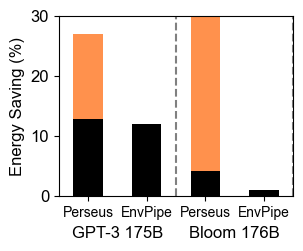

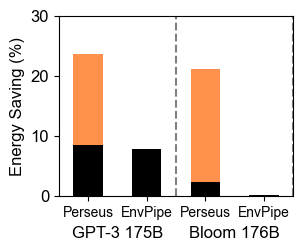

In [12]:
intrinsic_color = "black"
extrinsic_color = "#FF914D"

model_name = {
    "gpt3-175b": "GPT-3 175B",
    "bloom": "Bloom 176B",
}

for name, grp in bloats[(bloats.model.isin(["gpt3-175b","bloom"])) & (bloats.sf == 1.2) & ((bloats.num_pp == 4) | (bloats.num_pp == 16))].groupby("device"):
    _, ax = plt.subplots(figsize=(3, 2.5))
    grp.plot.bar(y="saving", ax=ax, color=extrinsic_color)
    grp.plot.bar(y="int_saving", ax=ax, color=intrinsic_color)
    ax.set_xticklabels(grp.framework, rotation=0, fontsize=10)
    ax.set_ylabel("Energy Saving (%)")
    ax.set_ylim(0, 30)

    display(grp.filter(["model","device","num_mb","framework","int_saving_pp","saving_pp","saving","tstar"]))

    for i, (_, model) in enumerate(grp["model"].items()):
        if i % 2 == 0:
            continue
        ax.axvline(x=i + 0.5, linestyle="--", color="grey")
        ax.text(i - 0.5, -5, model_name[model], ha="center", va="top", fontdict={"fontsize": 12})

    # Draw legend separately
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()

    plt.tight_layout(pad=0.5)

### Intrinsic bloat reduction without stragglers

*Table 6*

In [13]:
# NOTE: The value of `int_saving_pp` is all the same regardless of the slowdown factor.
#       We're just setting it to any random number to just fetch out one set.
for model in models:
    for device in devices:
        filtered_df = bloats[(bloats.model == model) & (bloats.device == device) & (bloats.sf == 1.2) & (bloats.framework == system_name)]
        filtered_df = filtered_df.filter(["model","device","num_mb","num_pp","int_saving_pp"])
        display(filtered_df)

,model,device,num_mb,num_pp,int_saving_pp
38,gpt3-175b,a100_sxm,12,128,15.201604
138,gpt3-175b,a100_sxm,24,64,14.190355
238,gpt3-175b,a100_sxm,48,32,13.616616
338,gpt3-175b,a100_sxm,96,16,13.319138


,model,device,num_mb,num_pp,int_saving_pp
438,gpt3-175b,a40,12,128,11.810657
538,gpt3-175b,a40,24,64,10.220271
638,gpt3-175b,a40,48,32,9.340778
738,gpt3-175b,a40,96,16,8.878493


,model,device,num_mb,num_pp,int_saving_pp
838,bloom,a100_sxm,12,128,10.471891
938,bloom,a100_sxm,24,64,7.064365
1038,bloom,a100_sxm,48,32,5.234097
1138,bloom,a100_sxm,96,16,4.284563


,model,device,num_mb,num_pp,int_saving_pp
1238,bloom,a40,12,128,6.973716
1338,bloom,a40,24,64,4.488244
1438,bloom,a40,48,32,3.122653
1538,bloom,a40,96,16,2.405541


### Intrinsic + extrinsic bloat savings with stragglers

*Figure 8*

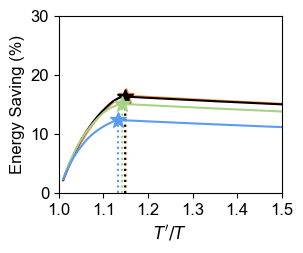

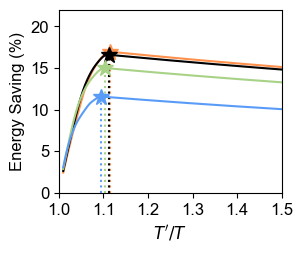

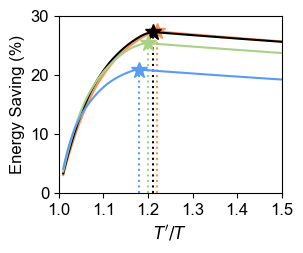

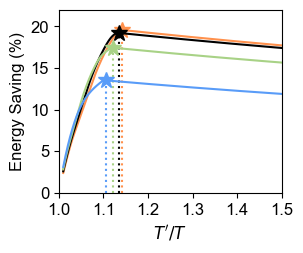

In [14]:
mb_color = {
    16: "#ff914d",
    32: "black",
    64: "#A8D286",
    128: "#599CF8",
}

for model in models:
    for device in devices:

        plt.figure(figsize=(3, 2.5))
        ax = plt.gca()

        filtered_df = bloats[(bloats.model == model) & (bloats.device == device) & (bloats.framework == system_name)]

        for num_pp, grp in filtered_df.groupby("num_pp"):
            grp = grp.sort_values(by="sf")

            xnew = np.linspace(grp["sf"].min(), grp["sf"].max(), 1000)
            tck = splrep(grp["sf"], grp["ext_saving"], s=0)
            ynew = BSpline(*tck)(xnew)
            plt.plot(xnew, ynew, label=num_pp, color=mb_color[num_pp])
            tstar = (xnew[ynew.argmax()], ynew[ynew.argmax()])

            plt.vlines(tstar[0], 0, tstar[1], color=mb_color[num_pp], linestyle="dotted")
            plt.plot(tstar[0], tstar[1], marker="*", markersize=12, color=mb_color[num_pp])

        handles, labels = ax.get_legend_handles_labels()
        ax.legend().remove()

        ax.set_xlim(left=1.0, right=1.5)
        
        if device == "a100" and model == "gpt3-175b":
            ytop = 2
        elif device == "a100" and model == "bloom":
            ytop = 20
        elif "a100" in device:
            ytop = 30
        else:
            ytop = 22
        ax.set_ylim(bottom=0, top=ytop)
        
        plt.xlabel("$T' / T$")
        plt.ylabel("Energy Saving (%)")
        plt.xticks(np.arange(1.0, 1.51, step=0.1))

        plt.tight_layout(pad=0.5)